In [1]:
import quandl
quandl.ApiConfig.api_key = '1w1X-kbMsxdg4Ts1disD'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
price_table = quandl.get_table('SHARADAR/SEP', 
                               ticker=['AMD', 'INTC',
                                       'BAC', 'C',
                                       'F', 'GM',
                                       'T', 'CMCSA',
                                       'AAPL', 'MSFT', 
                                       'UAL', 'AAL',
                                       'KO', 'PEP',
                                       'XOM', 'CVX'
                                      ]
                               , paginate=True)

In [3]:
sorted_table = price_table.sort_values(by=['ticker','date'], ascending=True).copy()
tickers = sorted(list(set(sorted_table['ticker'])))
price_stock = price_table[price_table['ticker']==tickers[0]][['date','close']].sort_values(by='date', ascending=True)
price_stock.reset_index(inplace=True)

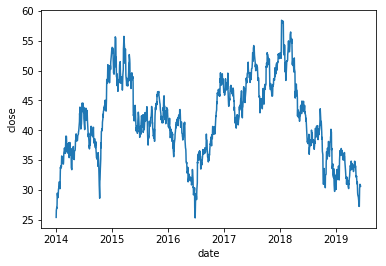

In [4]:
sns.lineplot(x='date', y='close', data=price_stock)

In [5]:
close_df = pd.DataFrame()
close_df['date'] = price_stock['date']
volume_df = pd.DataFrame()
close_df['date'] = price_stock['date']

for ticker in tickers:
    close_df[ticker] = list(sorted_table[sorted_table['ticker']==ticker]['close'])
    volume_ticker = 'v_' + ticker
    volume_df[volume_ticker] = list(sorted_table[sorted_table['ticker']==ticker]['volume'])

no_date_df = close_df[list(close_df.columns)[1:]]
return_df = no_date_df/no_date_df.shift(1) - 1

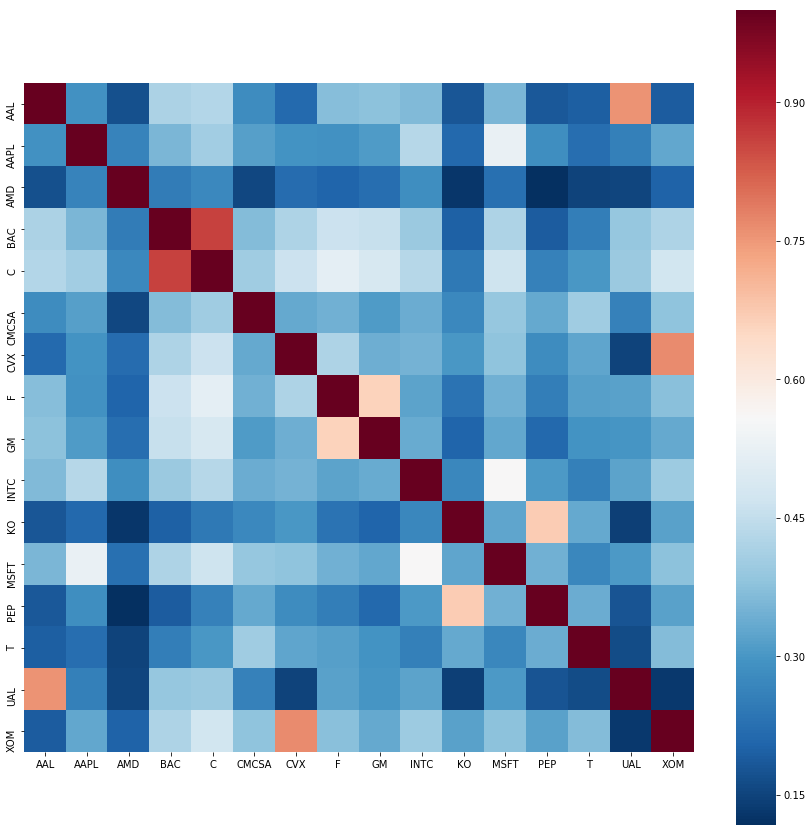

In [6]:
stock_corr = return_df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(stock_corr, square=True, cmap="RdBu_r");

In [7]:
def slice_data(train_perc, stocks_to_trade):
    train_len = int(return_df.shape[0] * (train_perc))
    volume_to_trade = ['v_'+ticker for ticker in stocks_to_trade]
    for i in volume_to_trade:
        stocks_to_trade.append(i)

    train = return_df_2[stocks_to_trade][1:train_len].copy()
    train['diff'] = train[stocks_to_trade[0]] - train[stocks_to_trade[1]]
    train.reset_index(inplace=True, drop=True)

    test = return_df_2[stocks_to_trade][train_len:-400].copy()
    test['diff'] = test[stocks_to_trade[0]] - test[stocks_to_trade[1]]
    test.reset_index(inplace=True, drop=True)

    true_test = return_df_2[stocks_to_trade][-400:].copy()
    true_test['diff'] = true_test[stocks_to_trade[0]] - true_test[stocks_to_trade[1]]
    true_test.reset_index(inplace=True, drop=True)

    feature_names = volume_to_trade
    feature_names.append('diff')
    
    return train, test, true_test, feature_names

In [8]:
def make_variables(dataset, lags, look_back, predict_window):
    features = lags+1
    start = look_back
    stop = len(dataset) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, features

In [12]:
# Create and fit the LSTM network

def train_lstm(train, feature_names, lags, look_back, predict_window):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y

    model = Sequential()
    model.add(LSTM(32, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='squared_hinge', optimizer='adam')
    model.fit(train_X, train_Y, epochs=300, batch_size=10, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [13]:
# Expanding window test where I fit the model to new data each day

def run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window):
    predictions_test = []
    actuals_test = []
    print(expand_set.shape[0] - 1)

    for i in range(0, expand_set.shape[0] - 1):
        print(i)
        curr_row = expand_set[i]
        test_row = expand_set[i+1]
        dataset = np.append(dataset, curr_row, axis=0)
        lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
        train_X = lstm_in_X
        train_Y = lstm_in_Y
    
        # Fit the data all the way up to curr_row (today)
        if i%1 == 0:
            model_test.fit(train_X, train_Y, epochs=10, batch_size=25, verbose=1)
    
        # Predict the next day (out of sample) - data for next day is in test_row
        dataset_test = np.append(dataset, test_row, axis=0)
        lstm_in_X_test, lstm_in_Y_test, features = make_variables(dataset_test, lags, look_back, predict_window)
        test_X = lstm_in_X_test
        pred_Y_test = model_test.predict(test_X)
        predict_test = pred_Y_test[-1,-1]
        actual_test = test_row[-1,-1]
        # Store predictions and actuals to for calculating money made and plotting
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        
    return predictions_test, actuals_test

In [17]:
# Main - for running the pipeline

train_perc = 0.40
stocks_to_trade = ['BAC','C']

lags = 50
look_back = 5       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

return_df_2 = pd.concat([return_df, volume_df], axis=1)

train, test, true_test, feature_names = slice_data(train_perc, stocks_to_trade)
expand_set = np.matrix(test[feature_names])
model_train, dataset, train_X, train_Y, predictions_train, actuals_train = train_lstm(train, feature_names, lags, look_back, predict_window)
model_test = model_train
predictions_test, actuals_test = run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window)

Epoch 1/300
490/490 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 2/300
490/490 [==============================] - 0s 655us/step - loss: 1.0000
Epoch 3/300
490/490 [==============================] - 0s 625us/step - loss: 1.0000
Epoch 4/300
490/490 [==============================] - 0s 632us/step - loss: 0.9999
Epoch 5/300
490/490 [==============================] - 0s 653us/step - loss: 0.9999
Epoch 6/300
490/490 [==============================] - 0s 630us/step - loss: 0.9998
Epoch 7/300
490/490 [==============================] - 0s 634us/step - loss: 0.9998
Epoch 8/300
490/490 [==============================] - 0s 639us/step - loss: 0.9995
Epoch 9/300
490/490 [==============================] - 0s 663us/step - loss: 0.9991
Epoch 10/300
490/490 [==============================] - 0s 640us/step - loss: 0.9985
Epoch 11/300
490/490 [==============================] - 0s 638us/step - loss: 0.9974
Epoch 12/300
490/490 [==============================] - 0s 631us/step - loss

490/490 [==============================] - 0s 584us/step - loss: 0.8716
Epoch 98/300
490/490 [==============================] - 0s 632us/step - loss: 0.8698
Epoch 99/300
490/490 [==============================] - 0s 631us/step - loss: 0.8695
Epoch 100/300
490/490 [==============================] - 0s 651us/step - loss: 0.8678 0s - loss: 0.
Epoch 101/300
490/490 [==============================] - 0s 603us/step - loss: 0.8682
Epoch 102/300
490/490 [==============================] - 0s 616us/step - loss: 0.8678
Epoch 103/300
490/490 [==============================] - 0s 648us/step - loss: 0.8660
Epoch 104/300
490/490 [==============================] - 0s 628us/step - loss: 0.8653
Epoch 105/300
490/490 [==============================] - 0s 633us/step - loss: 0.8635
Epoch 106/300
490/490 [==============================] - 0s 629us/step - loss: 0.8646
Epoch 107/300
490/490 [==============================] - 0s 606us/step - loss: 0.8623
Epoch 108/300
490/490 [==============================] -

490/490 [==============================] - 0s 598us/step - loss: 0.7990
Epoch 193/300
490/490 [==============================] - 0s 598us/step - loss: 0.7988
Epoch 194/300
490/490 [==============================] - 0s 599us/step - loss: 0.7974
Epoch 195/300
490/490 [==============================] - 0s 607us/step - loss: 0.7976
Epoch 196/300
490/490 [==============================] - 0s 602us/step - loss: 0.7983
Epoch 197/300
490/490 [==============================] - 0s 598us/step - loss: 0.7981
Epoch 198/300
490/490 [==============================] - 0s 618us/step - loss: 0.7961
Epoch 199/300
490/490 [==============================] - 0s 689us/step - loss: 0.7962
Epoch 200/300
490/490 [==============================] - 0s 611us/step - loss: 0.7951
Epoch 201/300
490/490 [==============================] - 0s 608us/step - loss: 0.7948
Epoch 202/300
490/490 [==============================] - 0s 622us/step - loss: 0.7920
Epoch 203/300
490/490 [==============================] - 0s 626us/st

490/490 [==============================] - 0s 633us/step - loss: 0.7428
Epoch 288/300
490/490 [==============================] - 0s 629us/step - loss: 0.7434
Epoch 289/300
490/490 [==============================] - 0s 603us/step - loss: 0.7432
Epoch 290/300
490/490 [==============================] - 0s 612us/step - loss: 0.7420
Epoch 291/300
490/490 [==============================] - 0s 602us/step - loss: 0.7423
Epoch 292/300
490/490 [==============================] - 0s 590us/step - loss: 0.7423
Epoch 293/300
490/490 [==============================] - 0s 642us/step - loss: 0.7424
Epoch 294/300
490/490 [==============================] - 0s 626us/step - loss: 0.7392
Epoch 295/300
490/490 [==============================] - 0s 592us/step - loss: 0.7404
Epoch 296/300
490/490 [==============================] - 0s 553us/step - loss: 0.7394
Epoch 297/300
490/490 [==============================] - 0s 616us/step - loss: 0.7409
Epoch 298/300
490/490 [==============================] - 0s 595us/st

499/499 [==============================] - 0s 239us/step - loss: 0.7109
Epoch 6/10
499/499 [==============================] - 0s 242us/step - loss: 0.7099
Epoch 7/10
499/499 [==============================] - 0s 234us/step - loss: 0.7136
Epoch 8/10
499/499 [==============================] - 0s 219us/step - loss: 0.7111
Epoch 9/10
499/499 [==============================] - 0s 221us/step - loss: 0.7108
Epoch 10/10
499/499 [==============================] - 0s 223us/step - loss: 0.7104
9
Epoch 1/10
500/500 [==============================] - 0s 237us/step - loss: 0.7089
Epoch 2/10
500/500 [==============================] - 0s 206us/step - loss: 0.7098
Epoch 3/10
500/500 [==============================] - 0s 210us/step - loss: 0.7108
Epoch 4/10
500/500 [==============================] - 0s 237us/step - loss: 0.7087
Epoch 5/10
500/500 [==============================] - 0s 247us/step - loss: 0.7084
Epoch 6/10
500/500 [==============================] - 0s 242us/step - loss: 0.7068
Epoch 7/10
5

509/509 [==============================] - 0s 258us/step - loss: 0.6816
Epoch 4/10
509/509 [==============================] - 0s 248us/step - loss: 0.6833
Epoch 5/10
509/509 [==============================] - 0s 250us/step - loss: 0.6799
Epoch 6/10
509/509 [==============================] - 0s 251us/step - loss: 0.6802
Epoch 7/10
509/509 [==============================] - 0s 245us/step - loss: 0.6803
Epoch 8/10
509/509 [==============================] - 0s 253us/step - loss: 0.6799
Epoch 9/10
509/509 [==============================] - 0s 245us/step - loss: 0.6789
Epoch 10/10
509/509 [==============================] - 0s 226us/step - loss: 0.6771
19
Epoch 1/10
510/510 [==============================] - 0s 245us/step - loss: 0.6784
Epoch 2/10
510/510 [==============================] - 0s 251us/step - loss: 0.6772
Epoch 3/10
510/510 [==============================] - 0s 246us/step - loss: 0.6776
Epoch 4/10
510/510 [==============================] - 0s 252us/step - loss: 0.6765
Epoch 5/10


519/519 [==============================] - 0s 243us/step - loss: 0.6541
Epoch 2/10
519/519 [==============================] - 0s 247us/step - loss: 0.6511
Epoch 3/10
519/519 [==============================] - 0s 252us/step - loss: 0.6498
Epoch 4/10
519/519 [==============================] - 0s 246us/step - loss: 0.6490
Epoch 5/10
519/519 [==============================] - 0s 263us/step - loss: 0.6487
Epoch 6/10
519/519 [==============================] - 0s 209us/step - loss: 0.6490
Epoch 7/10
519/519 [==============================] - 0s 212us/step - loss: 0.6495
Epoch 8/10
519/519 [==============================] - 0s 212us/step - loss: 0.6485
Epoch 9/10
519/519 [==============================] - 0s 213us/step - loss: 0.6493
Epoch 10/10
519/519 [==============================] - 0s 217us/step - loss: 0.6504
29
Epoch 1/10
520/520 [==============================] - 0s 243us/step - loss: 0.6510
Epoch 2/10
520/520 [==============================] - 0s 250us/step - loss: 0.6464
Epoch 3/10


528/528 [==============================] - 0s 246us/step - loss: 0.6229
Epoch 10/10
528/528 [==============================] - 0s 247us/step - loss: 0.6240
38
Epoch 1/10
529/529 [==============================] - 0s 245us/step - loss: 0.6190
Epoch 2/10
529/529 [==============================] - 0s 260us/step - loss: 0.6227
Epoch 3/10
529/529 [==============================] - 0s 251us/step - loss: 0.6203
Epoch 4/10
529/529 [==============================] - 0s 254us/step - loss: 0.6211
Epoch 5/10
529/529 [==============================] - 0s 248us/step - loss: 0.6216
Epoch 6/10
529/529 [==============================] - 0s 247us/step - loss: 0.6201
Epoch 7/10
529/529 [==============================] - 0s 253us/step - loss: 0.6169
Epoch 8/10
529/529 [==============================] - 0s 264us/step - loss: 0.6161
Epoch 9/10
529/529 [==============================] - 0s 248us/step - loss: 0.6168
Epoch 10/10
529/529 [==============================] - 0s 249us/step - loss: 0.6201
39
Epoch 1

538/538 [==============================] - 0s 263us/step - loss: 0.5983
Epoch 8/10
538/538 [==============================] - 0s 255us/step - loss: 0.5959
Epoch 9/10
538/538 [==============================] - 0s 250us/step - loss: 0.5934
Epoch 10/10
538/538 [==============================] - 0s 255us/step - loss: 0.5936
48
Epoch 1/10
539/539 [==============================] - 0s 267us/step - loss: 0.5947
Epoch 2/10
539/539 [==============================] - 0s 384us/step - loss: 0.5940
Epoch 3/10
539/539 [==============================] - 0s 259us/step - loss: 0.5936
Epoch 4/10
539/539 [==============================] - 0s 272us/step - loss: 0.5950
Epoch 5/10
539/539 [==============================] - 0s 257us/step - loss: 0.5926
Epoch 6/10
539/539 [==============================] - 0s 262us/step - loss: 0.5946
Epoch 7/10
539/539 [==============================] - 0s 254us/step - loss: 0.5926
Epoch 8/10
539/539 [==============================] - 0s 268us/step - loss: 0.5928
Epoch 9/10


548/548 [==============================] - 0s 258us/step - loss: 0.5726
Epoch 6/10
548/548 [==============================] - 0s 244us/step - loss: 0.5753
Epoch 7/10
548/548 [==============================] - 0s 248us/step - loss: 0.5730
Epoch 8/10
548/548 [==============================] - 0s 248us/step - loss: 0.5733
Epoch 9/10
548/548 [==============================] - 0s 225us/step - loss: 0.5709
Epoch 10/10
548/548 [==============================] - 0s 237us/step - loss: 0.5753
58
Epoch 1/10
549/549 [==============================] - 0s 258us/step - loss: 0.5758
Epoch 2/10
549/549 [==============================] - 0s 247us/step - loss: 0.5737
Epoch 3/10
549/549 [==============================] - 0s 246us/step - loss: 0.5723
Epoch 4/10
549/549 [==============================] - 0s 251us/step - loss: 0.5724
Epoch 5/10
549/549 [==============================] - 0s 247us/step - loss: 0.5706
Epoch 6/10
549/549 [==============================] - 0s 248us/step - loss: 0.5685
Epoch 7/10


558/558 [==============================] - 0s 248us/step - loss: 0.5545
Epoch 4/10
558/558 [==============================] - 0s 252us/step - loss: 0.5567
Epoch 5/10
558/558 [==============================] - 0s 256us/step - loss: 0.5577
Epoch 6/10
558/558 [==============================] - 0s 265us/step - loss: 0.5533
Epoch 7/10
558/558 [==============================] - 0s 254us/step - loss: 0.5549
Epoch 8/10
558/558 [==============================] - 0s 257us/step - loss: 0.5528
Epoch 9/10
558/558 [==============================] - 0s 259us/step - loss: 0.5554
Epoch 10/10
558/558 [==============================] - 0s 255us/step - loss: 0.5548
68
Epoch 1/10
559/559 [==============================] - 0s 251us/step - loss: 0.5532
Epoch 2/10
559/559 [==============================] - 0s 262us/step - loss: 0.5516
Epoch 3/10
559/559 [==============================] - 0s 257us/step - loss: 0.5531
Epoch 4/10
559/559 [==============================] - 0s 251us/step - loss: 0.5559
Epoch 5/10


568/568 [==============================] - 0s 258us/step - loss: 0.5349
Epoch 2/10
568/568 [==============================] - 0s 257us/step - loss: 0.5369
Epoch 3/10
568/568 [==============================] - 0s 255us/step - loss: 0.5373
Epoch 4/10
568/568 [==============================] - 0s 258us/step - loss: 0.5393
Epoch 5/10
568/568 [==============================] - 0s 264us/step - loss: 0.5402
Epoch 6/10
568/568 [==============================] - 0s 259us/step - loss: 0.5397
Epoch 7/10
568/568 [==============================] - 0s 258us/step - loss: 0.5398
Epoch 8/10
568/568 [==============================] - 0s 255us/step - loss: 0.5380
Epoch 9/10
568/568 [==============================] - 0s 257us/step - loss: 0.5368
Epoch 10/10
568/568 [==============================] - 0s 258us/step - loss: 0.5394
78
Epoch 1/10
569/569 [==============================] - 0s 256us/step - loss: 0.5377
Epoch 2/10
569/569 [==============================] - 0s 262us/step - loss: 0.5383
Epoch 3/10


577/577 [==============================] - 0s 233us/step - loss: 0.5203
Epoch 10/10
577/577 [==============================] - 0s 255us/step - loss: 0.5173
87
Epoch 1/10
578/578 [==============================] - 0s 267us/step - loss: 0.5183
Epoch 2/10
578/578 [==============================] - 0s 260us/step - loss: 0.5167
Epoch 3/10
578/578 [==============================] - 0s 269us/step - loss: 0.5221
Epoch 4/10
578/578 [==============================] - 0s 262us/step - loss: 0.5204
Epoch 5/10
578/578 [==============================] - 0s 266us/step - loss: 0.5174
Epoch 6/10
578/578 [==============================] - 0s 265us/step - loss: 0.5172
Epoch 7/10
578/578 [==============================] - 0s 257us/step - loss: 0.5186
Epoch 8/10
578/578 [==============================] - 0s 256us/step - loss: 0.5260
Epoch 9/10
578/578 [==============================] - 0s 247us/step - loss: 0.5183
Epoch 10/10
578/578 [==============================] - 0s 265us/step - loss: 0.5193
88
Epoch 1

587/587 [==============================] - 0s 254us/step - loss: 0.4986
Epoch 8/10
587/587 [==============================] - 0s 256us/step - loss: 0.5019
Epoch 9/10
587/587 [==============================] - 0s 257us/step - loss: 0.5029
Epoch 10/10
587/587 [==============================] - 0s 268us/step - loss: 0.5011
97
Epoch 1/10
588/588 [==============================] - 0s 250us/step - loss: 0.5023
Epoch 2/10
588/588 [==============================] - 0s 254us/step - loss: 0.5007
Epoch 3/10
588/588 [==============================] - 0s 250us/step - loss: 0.4992
Epoch 4/10
588/588 [==============================] - 0s 258us/step - loss: 0.4988
Epoch 5/10
588/588 [==============================] - 0s 253us/step - loss: 0.4996
Epoch 6/10
588/588 [==============================] - 0s 260us/step - loss: 0.4976
Epoch 7/10
588/588 [==============================] - 0s 240us/step - loss: 0.4968
Epoch 8/10
588/588 [==============================] - 0s 229us/step - loss: 0.4970
Epoch 9/10


597/597 [==============================] - 0s 261us/step - loss: 0.4878
Epoch 6/10
597/597 [==============================] - 0s 264us/step - loss: 0.4830
Epoch 7/10
597/597 [==============================] - 0s 506us/step - loss: 0.4831
Epoch 8/10
597/597 [==============================] - 0s 235us/step - loss: 0.4844
Epoch 9/10
597/597 [==============================] - 0s 210us/step - loss: 0.4827
Epoch 10/10
597/597 [==============================] - 0s 208us/step - loss: 0.4869
107
Epoch 1/10
598/598 [==============================] - 0s 273us/step - loss: 0.4859
Epoch 2/10
598/598 [==============================] - 0s 283us/step - loss: 0.4811
Epoch 3/10
598/598 [==============================] - 0s 233us/step - loss: 0.4855
Epoch 4/10
598/598 [==============================] - 0s 211us/step - loss: 0.4842
Epoch 5/10
598/598 [==============================] - 0s 215us/step - loss: 0.4808
Epoch 6/10
598/598 [==============================] - 0s 218us/step - loss: 0.4894
Epoch 7/10

607/607 [==============================] - 0s 265us/step - loss: 0.4730
Epoch 4/10
607/607 [==============================] - 0s 265us/step - loss: 0.4729
Epoch 5/10
607/607 [==============================] - 0s 251us/step - loss: 0.4712
Epoch 6/10
607/607 [==============================] - 0s 259us/step - loss: 0.4680
Epoch 7/10
607/607 [==============================] - 0s 254us/step - loss: 0.4739
Epoch 8/10
607/607 [==============================] - 0s 253us/step - loss: 0.4715
Epoch 9/10
607/607 [==============================] - 0s 264us/step - loss: 0.4730
Epoch 10/10
607/607 [==============================] - 0s 253us/step - loss: 0.4741
117
Epoch 1/10
608/608 [==============================] - 0s 251us/step - loss: 0.4723
Epoch 2/10
608/608 [==============================] - 0s 223us/step - loss: 0.4718
Epoch 3/10
608/608 [==============================] - 0s 260us/step - loss: 0.4677
Epoch 4/10
608/608 [==============================] - 0s 258us/step - loss: 0.4656
Epoch 5/10

617/617 [==============================] - 0s 251us/step - loss: 0.4606
Epoch 2/10
617/617 [==============================] - 0s 253us/step - loss: 0.4615
Epoch 3/10
617/617 [==============================] - 0s 260us/step - loss: 0.4670
Epoch 4/10
617/617 [==============================] - 0s 261us/step - loss: 0.4597
Epoch 5/10
617/617 [==============================] - 0s 257us/step - loss: 0.4602
Epoch 6/10
617/617 [==============================] - 0s 253us/step - loss: 0.4594
Epoch 7/10
617/617 [==============================] - 0s 262us/step - loss: 0.4594
Epoch 8/10
617/617 [==============================] - 0s 240us/step - loss: 0.4605
Epoch 9/10
617/617 [==============================] - 0s 259us/step - loss: 0.4611
Epoch 10/10
617/617 [==============================] - 0s 271us/step - loss: 0.4596
127
Epoch 1/10
618/618 [==============================] - 0s 265us/step - loss: 0.4587
Epoch 2/10
618/618 [==============================] - 0s 260us/step - loss: 0.4624
Epoch 3/10

626/626 [==============================] - 0s 259us/step - loss: 0.4416
Epoch 10/10
626/626 [==============================] - 0s 252us/step - loss: 0.4435
136
Epoch 1/10
627/627 [==============================] - 0s 267us/step - loss: 0.4454
Epoch 2/10
627/627 [==============================] - 0s 259us/step - loss: 0.4459
Epoch 3/10
627/627 [==============================] - 0s 273us/step - loss: 0.4461
Epoch 4/10
627/627 [==============================] - 0s 258us/step - loss: 0.4484
Epoch 5/10
627/627 [==============================] - 0s 269us/step - loss: 0.4471
Epoch 6/10
627/627 [==============================] - 0s 266us/step - loss: 0.4461
Epoch 7/10
627/627 [==============================] - 0s 252us/step - loss: 0.4423
Epoch 8/10
627/627 [==============================] - 0s 265us/step - loss: 0.4415
Epoch 9/10
627/627 [==============================] - 0s 270us/step - loss: 0.4406
Epoch 10/10
627/627 [==============================] - 0s 260us/step - loss: 0.4494
137
Epoch

636/636 [==============================] - 0s 267us/step - loss: 0.4309
Epoch 8/10
636/636 [==============================] - 0s 264us/step - loss: 0.4304
Epoch 9/10
636/636 [==============================] - 0s 264us/step - loss: 0.4286
Epoch 10/10
636/636 [==============================] - 0s 258us/step - loss: 0.4297
146
Epoch 1/10
637/637 [==============================] - 0s 262us/step - loss: 0.4321
Epoch 2/10
637/637 [==============================] - 0s 267us/step - loss: 0.4334
Epoch 3/10
637/637 [==============================] - 0s 263us/step - loss: 0.4300
Epoch 4/10
637/637 [==============================] - 0s 256us/step - loss: 0.4281
Epoch 5/10
637/637 [==============================] - 0s 264us/step - loss: 0.4283
Epoch 6/10
637/637 [==============================] - 0s 261us/step - loss: 0.4326
Epoch 7/10
637/637 [==============================] - 0s 265us/step - loss: 0.4294
Epoch 8/10
637/637 [==============================] - 0s 258us/step - loss: 0.4326
Epoch 9/10

646/646 [==============================] - 0s 251us/step - loss: 0.4215
Epoch 6/10
646/646 [==============================] - 0s 250us/step - loss: 0.4212
Epoch 7/10
646/646 [==============================] - 0s 251us/step - loss: 0.4213
Epoch 8/10
646/646 [==============================] - 0s 267us/step - loss: 0.4192
Epoch 9/10
646/646 [==============================] - 0s 252us/step - loss: 0.4203
Epoch 10/10
646/646 [==============================] - 0s 253us/step - loss: 0.4181
156
Epoch 1/10
647/647 [==============================] - 0s 249us/step - loss: 0.4229
Epoch 2/10
647/647 [==============================] - 0s 249us/step - loss: 0.4229
Epoch 3/10
647/647 [==============================] - 0s 248us/step - loss: 0.4219
Epoch 4/10
647/647 [==============================] - 0s 251us/step - loss: 0.4199
Epoch 5/10
647/647 [==============================] - 0s 252us/step - loss: 0.4181
Epoch 6/10
647/647 [==============================] - 0s 266us/step - loss: 0.4201
Epoch 7/10

656/656 [==============================] - 0s 254us/step - loss: 0.4071
Epoch 4/10
656/656 [==============================] - 0s 257us/step - loss: 0.4071
Epoch 5/10
656/656 [==============================] - 0s 253us/step - loss: 0.4050
Epoch 6/10
656/656 [==============================] - 0s 259us/step - loss: 0.4079
Epoch 7/10
656/656 [==============================] - 0s 252us/step - loss: 0.4046
Epoch 8/10
656/656 [==============================] - 0s 254us/step - loss: 0.4012
Epoch 9/10
656/656 [==============================] - 0s 247us/step - loss: 0.4067
Epoch 10/10
656/656 [==============================] - 0s 248us/step - loss: 0.4075
166
Epoch 1/10
657/657 [==============================] - 0s 253us/step - loss: 0.4045
Epoch 2/10
657/657 [==============================] - 0s 270us/step - loss: 0.4061
Epoch 3/10
657/657 [==============================] - 0s 251us/step - loss: 0.4067
Epoch 4/10
657/657 [==============================] - 0s 254us/step - loss: 0.4078
Epoch 5/10

666/666 [==============================] - 0s 258us/step - loss: 0.3928
Epoch 2/10
666/666 [==============================] - 0s 267us/step - loss: 0.3939
Epoch 3/10
666/666 [==============================] - 0s 260us/step - loss: 0.3923
Epoch 4/10
666/666 [==============================] - 0s 253us/step - loss: 0.3948
Epoch 5/10
666/666 [==============================] - 0s 256us/step - loss: 0.3978
Epoch 6/10
666/666 [==============================] - 0s 264us/step - loss: 0.3950
Epoch 7/10
666/666 [==============================] - 0s 257us/step - loss: 0.3955
Epoch 8/10
666/666 [==============================] - 0s 250us/step - loss: 0.3912
Epoch 9/10
666/666 [==============================] - 0s 246us/step - loss: 0.3915
Epoch 10/10
666/666 [==============================] - 0s 255us/step - loss: 0.3949
176
Epoch 1/10
667/667 [==============================] - 0s 245us/step - loss: 0.3936
Epoch 2/10
667/667 [==============================] - 0s 240us/step - loss: 0.3899
Epoch 3/10

675/675 [==============================] - 0s 248us/step - loss: 0.3817
Epoch 10/10
675/675 [==============================] - 0s 244us/step - loss: 0.3802
185
Epoch 1/10
676/676 [==============================] - 0s 256us/step - loss: 0.3828
Epoch 2/10
676/676 [==============================] - 0s 243us/step - loss: 0.3870
Epoch 3/10
676/676 [==============================] - 0s 241us/step - loss: 0.4292
Epoch 4/10
676/676 [==============================] - 0s 220us/step - loss: 0.3932
Epoch 5/10
676/676 [==============================] - 0s 219us/step - loss: 0.3895
Epoch 6/10
676/676 [==============================] - 0s 219us/step - loss: 0.3856
Epoch 7/10
676/676 [==============================] - 0s 248us/step - loss: 0.3867
Epoch 8/10
676/676 [==============================] - 0s 254us/step - loss: 0.3779
Epoch 9/10
676/676 [==============================] - 0s 249us/step - loss: 0.3849
Epoch 10/10
676/676 [==============================] - 0s 248us/step - loss: 0.3819
186
Epoch

685/685 [==============================] - 0s 257us/step - loss: 0.3700
Epoch 8/10
685/685 [==============================] - 0s 258us/step - loss: 0.3716
Epoch 9/10
685/685 [==============================] - 0s 257us/step - loss: 0.3700
Epoch 10/10
685/685 [==============================] - 0s 258us/step - loss: 0.3695
195
Epoch 1/10
686/686 [==============================] - 0s 258us/step - loss: 0.3736
Epoch 2/10
686/686 [==============================] - 0s 251us/step - loss: 0.3723
Epoch 3/10
686/686 [==============================] - 0s 223us/step - loss: 0.3655
Epoch 4/10
686/686 [==============================] - 0s 245us/step - loss: 0.3716
Epoch 5/10
686/686 [==============================] - 0s 251us/step - loss: 0.3718
Epoch 6/10
686/686 [==============================] - 0s 259us/step - loss: 0.3695
Epoch 7/10
686/686 [==============================] - 0s 257us/step - loss: 0.3756
Epoch 8/10
686/686 [==============================] - 0s 258us/step - loss: 0.3746
Epoch 9/10

695/695 [==============================] - 0s 251us/step - loss: 0.3567
Epoch 6/10
695/695 [==============================] - 0s 249us/step - loss: 0.3586
Epoch 7/10
695/695 [==============================] - 0s 250us/step - loss: 0.3569
Epoch 8/10
695/695 [==============================] - 0s 243us/step - loss: 0.3604
Epoch 9/10
695/695 [==============================] - 0s 245us/step - loss: 0.3552
Epoch 10/10
695/695 [==============================] - 0s 254us/step - loss: 0.3578
205
Epoch 1/10
696/696 [==============================] - 0s 248us/step - loss: 0.3604
Epoch 2/10
696/696 [==============================] - 0s 242us/step - loss: 0.3628
Epoch 3/10
696/696 [==============================] - 0s 227us/step - loss: 0.3594
Epoch 4/10
696/696 [==============================] - 0s 236us/step - loss: 0.3557
Epoch 5/10
696/696 [==============================] - 0s 246us/step - loss: 0.3544
Epoch 6/10
696/696 [==============================] - 0s 246us/step - loss: 0.3588
Epoch 7/10

705/705 [==============================] - 0s 262us/step - loss: 0.3549
Epoch 4/10
705/705 [==============================] - 0s 265us/step - loss: 0.3529
Epoch 5/10
705/705 [==============================] - 0s 258us/step - loss: 0.3535
Epoch 6/10
705/705 [==============================] - 0s 262us/step - loss: 0.3561
Epoch 7/10
705/705 [==============================] - 0s 233us/step - loss: 0.3567
Epoch 8/10
705/705 [==============================] - 0s 237us/step - loss: 0.3550
Epoch 9/10
705/705 [==============================] - 0s 266us/step - loss: 0.3539
Epoch 10/10
705/705 [==============================] - 0s 266us/step - loss: 0.3555
215
Epoch 1/10
706/706 [==============================] - 0s 248us/step - loss: 0.3599
Epoch 2/10
706/706 [==============================] - 0s 249us/step - loss: 0.3581
Epoch 3/10
706/706 [==============================] - 0s 250us/step - loss: 0.3590
Epoch 4/10
706/706 [==============================] - 0s 250us/step - loss: 0.3546
Epoch 5/10

715/715 [==============================] - 0s 268us/step - loss: 0.3461
Epoch 2/10
715/715 [==============================] - 0s 249us/step - loss: 0.3459
Epoch 3/10
715/715 [==============================] - 0s 252us/step - loss: 0.3378
Epoch 4/10
715/715 [==============================] - 0s 256us/step - loss: 0.3384
Epoch 5/10
715/715 [==============================] - 0s 254us/step - loss: 0.3400
Epoch 6/10
715/715 [==============================] - 0s 266us/step - loss: 0.3379
Epoch 7/10
715/715 [==============================] - 0s 221us/step - loss: 0.3401
Epoch 8/10
715/715 [==============================] - 0s 208us/step - loss: 0.3374
Epoch 9/10
715/715 [==============================] - 0s 215us/step - loss: 0.3401
Epoch 10/10
715/715 [==============================] - 0s 231us/step - loss: 0.3400
225
Epoch 1/10
716/716 [==============================] - 0s 261us/step - loss: 0.3455
Epoch 2/10
716/716 [==============================] - 0s 255us/step - loss: 0.3424
Epoch 3/10

724/724 [==============================] - 0s 244us/step - loss: 0.3300
Epoch 10/10
724/724 [==============================] - 0s 227us/step - loss: 0.3322
234
Epoch 1/10
725/725 [==============================] - 0s 210us/step - loss: 0.3349
Epoch 2/10
725/725 [==============================] - 0s 222us/step - loss: 0.3297
Epoch 3/10
725/725 [==============================] - 0s 235us/step - loss: 0.3324
Epoch 4/10
725/725 [==============================] - 0s 253us/step - loss: 0.3288
Epoch 5/10
725/725 [==============================] - 0s 250us/step - loss: 0.3329
Epoch 6/10
725/725 [==============================] - 0s 247us/step - loss: 0.3294
Epoch 7/10
725/725 [==============================] - 0s 247us/step - loss: 0.3306
Epoch 8/10
725/725 [==============================] - 0s 251us/step - loss: 0.3303
Epoch 9/10
725/725 [==============================] - 0s 252us/step - loss: 0.3406
Epoch 10/10
725/725 [==============================] - 0s 254us/step - loss: 0.3425
235
Epoch

734/734 [==============================] - 0s 249us/step - loss: 0.3280
Epoch 8/10
734/734 [==============================] - 0s 262us/step - loss: 0.3327
Epoch 9/10
734/734 [==============================] - 0s 247us/step - loss: 0.3300
Epoch 10/10
734/734 [==============================] - 0s 252us/step - loss: 0.3252
244
Epoch 1/10
735/735 [==============================] - 0s 252us/step - loss: 0.3244
Epoch 2/10
735/735 [==============================] - 0s 247us/step - loss: 0.3203
Epoch 3/10
735/735 [==============================] - 0s 248us/step - loss: 0.3213
Epoch 4/10
735/735 [==============================] - 0s 261us/step - loss: 0.3214
Epoch 5/10
735/735 [==============================] - 0s 247us/step - loss: 0.3214
Epoch 6/10
735/735 [==============================] - 0s 248us/step - loss: 0.3238
Epoch 7/10
735/735 [==============================] - 0s 246us/step - loss: 0.3217
Epoch 8/10
735/735 [==============================] - 0s 247us/step - loss: 0.3150
Epoch 9/10

744/744 [==============================] - 0s 261us/step - loss: 0.3139
Epoch 6/10
744/744 [==============================] - 0s 254us/step - loss: 0.3128
Epoch 7/10
744/744 [==============================] - 0s 250us/step - loss: 0.3137
Epoch 8/10
744/744 [==============================] - 0s 245us/step - loss: 0.3148
Epoch 9/10
744/744 [==============================] - 0s 258us/step - loss: 0.3119
Epoch 10/10
744/744 [==============================] - 0s 246us/step - loss: 0.3139
254
Epoch 1/10
745/745 [==============================] - 0s 245us/step - loss: 0.3107
Epoch 2/10
745/745 [==============================] - 0s 245us/step - loss: 0.3112
Epoch 3/10
745/745 [==============================] - 0s 243us/step - loss: 0.3091
Epoch 4/10
745/745 [==============================] - 0s 252us/step - loss: 0.3148
Epoch 5/10
745/745 [==============================] - 0s 244us/step - loss: 0.3127
Epoch 6/10
745/745 [==============================] - 0s 243us/step - loss: 0.3136
Epoch 7/10

754/754 [==============================] - 0s 265us/step - loss: 0.3085
Epoch 4/10
754/754 [==============================] - 0s 266us/step - loss: 0.3073
Epoch 5/10
754/754 [==============================] - 0s 255us/step - loss: 0.3037
Epoch 6/10
754/754 [==============================] - 0s 261us/step - loss: 0.3051
Epoch 7/10
754/754 [==============================] - 0s 260us/step - loss: 0.3071
Epoch 8/10
754/754 [==============================] - 0s 254us/step - loss: 0.3048
Epoch 9/10
754/754 [==============================] - 0s 251us/step - loss: 0.3041
Epoch 10/10
754/754 [==============================] - 0s 261us/step - loss: 0.3038
264
Epoch 1/10
755/755 [==============================] - 0s 277us/step - loss: 0.3038
Epoch 2/10
755/755 [==============================] - 0s 290us/step - loss: 0.3019
Epoch 3/10
755/755 [==============================] - 0s 270us/step - loss: 0.3027
Epoch 4/10
755/755 [==============================] - 0s 298us/step - loss: 0.3029
Epoch 5/10

764/764 [==============================] - 0s 264us/step - loss: 0.3202
Epoch 2/10
764/764 [==============================] - 0s 270us/step - loss: 0.3100
Epoch 3/10
764/764 [==============================] - 0s 267us/step - loss: 0.3067
Epoch 4/10
764/764 [==============================] - 0s 257us/step - loss: 0.3045
Epoch 5/10
764/764 [==============================] - 0s 261us/step - loss: 0.3015
Epoch 6/10
764/764 [==============================] - 0s 246us/step - loss: 0.2988
Epoch 7/10
764/764 [==============================] - 0s 250us/step - loss: 0.3006
Epoch 8/10
764/764 [==============================] - 0s 240us/step - loss: 0.3035
Epoch 9/10
764/764 [==============================] - 0s 210us/step - loss: 0.3018
Epoch 10/10
764/764 [==============================] - 0s 215us/step - loss: 0.3021
274
Epoch 1/10
765/765 [==============================] - 0s 270us/step - loss: 0.3001
Epoch 2/10
765/765 [==============================] - 0s 281us/step - loss: 0.3023
Epoch 3/10

773/773 [==============================] - 0s 261us/step - loss: 0.2968
Epoch 10/10
773/773 [==============================] - 0s 360us/step - loss: 0.2968
283
Epoch 1/10
774/774 [==============================] - 0s 285us/step - loss: 0.2980
Epoch 2/10
774/774 [==============================] - 0s 284us/step - loss: 0.3047
Epoch 3/10
774/774 [==============================] - 0s 276us/step - loss: 0.2966
Epoch 4/10
774/774 [==============================] - 0s 267us/step - loss: 0.2938
Epoch 5/10
774/774 [==============================] - 0s 256us/step - loss: 0.2933
Epoch 6/10
774/774 [==============================] - 0s 241us/step - loss: 0.2955
Epoch 7/10
774/774 [==============================] - 0s 280us/step - loss: 0.3013
Epoch 8/10
774/774 [==============================] - 0s 256us/step - loss: 0.2979
Epoch 9/10
774/774 [==============================] - 0s 243us/step - loss: 0.2931
Epoch 10/10
774/774 [==============================] - 0s 267us/step - loss: 0.2923
284
Epoch

783/783 [==============================] - 0s 245us/step - loss: 0.2951
Epoch 8/10
783/783 [==============================] - 0s 244us/step - loss: 0.2899
Epoch 9/10
783/783 [==============================] - 0s 236us/step - loss: 0.2861
Epoch 10/10
783/783 [==============================] - 0s 248us/step - loss: 0.2865
293
Epoch 1/10
784/784 [==============================] - 0s 246us/step - loss: 0.2878
Epoch 2/10
784/784 [==============================] - 0s 256us/step - loss: 0.2924
Epoch 3/10
784/784 [==============================] - 0s 253us/step - loss: 0.2923
Epoch 4/10
784/784 [==============================] - 0s 285us/step - loss: 0.2908
Epoch 5/10
784/784 [==============================] - 0s 259us/step - loss: 0.2904
Epoch 6/10
784/784 [==============================] - 0s 242us/step - loss: 0.2900
Epoch 7/10
784/784 [==============================] - 0s 249us/step - loss: 0.2894
Epoch 8/10
784/784 [==============================] - 0s 267us/step - loss: 0.2888
Epoch 9/10

793/793 [==============================] - 0s 254us/step - loss: 0.2830
Epoch 6/10
793/793 [==============================] - 0s 255us/step - loss: 0.2830
Epoch 7/10
793/793 [==============================] - 0s 263us/step - loss: 0.2845
Epoch 8/10
793/793 [==============================] - 0s 253us/step - loss: 0.2831
Epoch 9/10
793/793 [==============================] - 0s 257us/step - loss: 0.2864
Epoch 10/10
793/793 [==============================] - 0s 253us/step - loss: 0.2798
303
Epoch 1/10
794/794 [==============================] - 0s 259us/step - loss: 0.2825
Epoch 2/10
794/794 [==============================] - 0s 253us/step - loss: 0.2841
Epoch 3/10
794/794 [==============================] - 0s 254us/step - loss: 0.2846
Epoch 4/10
794/794 [==============================] - 0s 256us/step - loss: 0.2887
Epoch 5/10
794/794 [==============================] - 0s 257us/step - loss: 0.2851
Epoch 6/10
794/794 [==============================] - 0s 255us/step - loss: 0.2876
Epoch 7/10

803/803 [==============================] - 0s 251us/step - loss: 0.2749
Epoch 4/10
803/803 [==============================] - 0s 253us/step - loss: 0.2741
Epoch 5/10
803/803 [==============================] - 0s 261us/step - loss: 0.2771
Epoch 6/10
803/803 [==============================] - 0s 254us/step - loss: 0.2751
Epoch 7/10
803/803 [==============================] - 0s 253us/step - loss: 0.2737
Epoch 8/10
803/803 [==============================] - 0s 256us/step - loss: 0.2739
Epoch 9/10
803/803 [==============================] - 0s 255us/step - loss: 0.2764
Epoch 10/10
803/803 [==============================] - 0s 260us/step - loss: 0.2732
313
Epoch 1/10
804/804 [==============================] - 0s 249us/step - loss: 0.2768
Epoch 2/10
804/804 [==============================] - 0s 255us/step - loss: 0.2758
Epoch 3/10
804/804 [==============================] - 0s 254us/step - loss: 0.2793
Epoch 4/10
804/804 [==============================] - 0s 262us/step - loss: 0.3058
Epoch 5/10

813/813 [==============================] - 0s 257us/step - loss: 0.2734
Epoch 2/10
813/813 [==============================] - 0s 251us/step - loss: 0.2731
Epoch 3/10
813/813 [==============================] - 0s 254us/step - loss: 0.2708
Epoch 4/10
813/813 [==============================] - 0s 253us/step - loss: 0.2712
Epoch 5/10
813/813 [==============================] - 0s 255us/step - loss: 0.2723
Epoch 6/10
813/813 [==============================] - 0s 261us/step - loss: 0.2723
Epoch 7/10
813/813 [==============================] - 0s 247us/step - loss: 0.2979
Epoch 8/10
813/813 [==============================] - 0s 270us/step - loss: 0.2772
Epoch 9/10
813/813 [==============================] - 0s 285us/step - loss: 0.2812
Epoch 10/10
813/813 [==============================] - 0s 283us/step - loss: 0.2721
323
Epoch 1/10
814/814 [==============================] - 0s 255us/step - loss: 0.2696
Epoch 2/10
814/814 [==============================] - 0s 275us/step - loss: 0.2936
Epoch 3/10

822/822 [==============================] - 0s 239us/step - loss: 0.2658
Epoch 10/10
822/822 [==============================] - 0s 237us/step - loss: 0.2656
332
Epoch 1/10
823/823 [==============================] - 0s 245us/step - loss: 0.2728
Epoch 2/10
823/823 [==============================] - 0s 242us/step - loss: 0.2725
Epoch 3/10
823/823 [==============================] - 0s 242us/step - loss: 0.2860
Epoch 4/10
823/823 [==============================] - 0s 240us/step - loss: 0.3002
Epoch 5/10
823/823 [==============================] - 0s 239us/step - loss: 0.3099
Epoch 6/10
823/823 [==============================] - 0s 248us/step - loss: 0.2844
Epoch 7/10
823/823 [==============================] - 0s 240us/step - loss: 0.2731
Epoch 8/10
823/823 [==============================] - 0s 244us/step - loss: 0.2717
Epoch 9/10
823/823 [==============================] - 0s 245us/step - loss: 0.2698
Epoch 10/10
823/823 [==============================] - 0s 240us/step - loss: 0.2692
333
Epoch

832/832 [==============================] - 0s 288us/step - loss: 0.2661
Epoch 8/10
832/832 [==============================] - 0s 273us/step - loss: 0.2608
Epoch 9/10
832/832 [==============================] - 0s 259us/step - loss: 0.2587
Epoch 10/10
832/832 [==============================] - 0s 271us/step - loss: 0.2547
342
Epoch 1/10
833/833 [==============================] - 0s 254us/step - loss: 0.2628
Epoch 2/10
833/833 [==============================] - 0s 273us/step - loss: 0.2580
Epoch 3/10
833/833 [==============================] - 0s 265us/step - loss: 0.2641
Epoch 4/10
833/833 [==============================] - 0s 232us/step - loss: 0.2623
Epoch 5/10
833/833 [==============================] - 0s 218us/step - loss: 0.2580
Epoch 6/10
833/833 [==============================] - 0s 220us/step - loss: 0.2633
Epoch 7/10
833/833 [==============================] - 0s 212us/step - loss: 0.2586
Epoch 8/10
833/833 [==============================] - 0s 220us/step - loss: 0.2585
Epoch 9/10

842/842 [==============================] - 0s 241us/step - loss: 0.2554
Epoch 6/10
842/842 [==============================] - 0s 250us/step - loss: 0.2533
Epoch 7/10
842/842 [==============================] - 0s 251us/step - loss: 0.2521
Epoch 8/10
842/842 [==============================] - 0s 239us/step - loss: 0.2525
Epoch 9/10
842/842 [==============================] - 0s 250us/step - loss: 0.2525
Epoch 10/10
842/842 [==============================] - 0s 259us/step - loss: 0.2558
352
Epoch 1/10
843/843 [==============================] - 0s 271us/step - loss: 0.2533
Epoch 2/10
843/843 [==============================] - 0s 245us/step - loss: 0.2550
Epoch 3/10
843/843 [==============================] - 0s 245us/step - loss: 0.2492
Epoch 4/10
843/843 [==============================] - 0s 246us/step - loss: 0.2568
Epoch 5/10
843/843 [==============================] - 0s 249us/step - loss: 0.2559
Epoch 6/10
843/843 [==============================] - 0s 243us/step - loss: 0.2591
Epoch 7/10

852/852 [==============================] - 0s 264us/step - loss: 0.2434
Epoch 4/10
852/852 [==============================] - 0s 279us/step - loss: 0.2432
Epoch 5/10
852/852 [==============================] - 0s 257us/step - loss: 0.2439
Epoch 6/10
852/852 [==============================] - 0s 267us/step - loss: 0.2458
Epoch 7/10
852/852 [==============================] - 0s 268us/step - loss: 0.2463
Epoch 8/10
852/852 [==============================] - 0s 262us/step - loss: 0.2441
Epoch 9/10
852/852 [==============================] - 0s 266us/step - loss: 0.2486
Epoch 10/10
852/852 [==============================] - 0s 265us/step - loss: 0.2444
362
Epoch 1/10
853/853 [==============================] - 0s 255us/step - loss: 0.2417
Epoch 2/10
853/853 [==============================] - 0s 244us/step - loss: 0.2613
Epoch 3/10
853/853 [==============================] - 0s 268us/step - loss: 0.2498
Epoch 4/10
853/853 [==============================] - 0s 266us/step - loss: 0.2476
Epoch 5/10

862/862 [==============================] - 0s 260us/step - loss: 0.2417
Epoch 2/10
862/862 [==============================] - 0s 256us/step - loss: 0.2406
Epoch 3/10
862/862 [==============================] - 0s 265us/step - loss: 0.2386
Epoch 4/10
862/862 [==============================] - 0s 234us/step - loss: 0.2384
Epoch 5/10
862/862 [==============================] - 0s 241us/step - loss: 0.2411
Epoch 6/10
862/862 [==============================] - 0s 222us/step - loss: 0.2374
Epoch 7/10
862/862 [==============================] - 0s 242us/step - loss: 0.2394
Epoch 8/10
862/862 [==============================] - 0s 235us/step - loss: 0.2395
Epoch 9/10
862/862 [==============================] - 0s 253us/step - loss: 0.2401
Epoch 10/10
862/862 [==============================] - 0s 248us/step - loss: 0.2364
372
Epoch 1/10
863/863 [==============================] - 0s 252us/step - loss: 0.2378
Epoch 2/10
863/863 [==============================] - 0s 266us/step - loss: 0.2383
Epoch 3/10

871/871 [==============================] - 0s 247us/step - loss: 0.2352
Epoch 10/10
871/871 [==============================] - 0s 244us/step - loss: 0.2349
381
Epoch 1/10
872/872 [==============================] - 0s 247us/step - loss: 0.2338
Epoch 2/10
872/872 [==============================] - 0s 247us/step - loss: 0.2326
Epoch 3/10
872/872 [==============================] - 0s 252us/step - loss: 0.2355
Epoch 4/10
872/872 [==============================] - 0s 246us/step - loss: 0.2373
Epoch 5/10
872/872 [==============================] - 0s 253us/step - loss: 0.2335
Epoch 6/10
872/872 [==============================] - 0s 251us/step - loss: 0.2328
Epoch 7/10
872/872 [==============================] - 0s 250us/step - loss: 0.2356
Epoch 8/10
872/872 [==============================] - 0s 245us/step - loss: 0.2324
Epoch 9/10
872/872 [==============================] - 0s 247us/step - loss: 0.2335
Epoch 10/10
872/872 [==============================] - 0s 245us/step - loss: 0.2318
382
Epoch

881/881 [==============================] - 0s 245us/step - loss: 0.2302
Epoch 8/10
881/881 [==============================] - 0s 250us/step - loss: 0.2289
Epoch 9/10
881/881 [==============================] - 0s 250us/step - loss: 0.2299
Epoch 10/10
881/881 [==============================] - 0s 254us/step - loss: 0.2309
391
Epoch 1/10
882/882 [==============================] - 0s 253us/step - loss: 0.2304
Epoch 2/10
882/882 [==============================] - 0s 256us/step - loss: 0.2312
Epoch 3/10
882/882 [==============================] - 0s 250us/step - loss: 0.2275
Epoch 4/10
882/882 [==============================] - 0s 249us/step - loss: 0.2287
Epoch 5/10
882/882 [==============================] - 0s 248us/step - loss: 0.2278
Epoch 6/10
882/882 [==============================] - 0s 248us/step - loss: 0.2306
Epoch 7/10
882/882 [==============================] - 0s 250us/step - loss: 0.2292
Epoch 8/10
882/882 [==============================] - 0s 245us/step - loss: 0.2263
Epoch 9/10

891/891 [==============================] - 0s 245us/step - loss: 0.2254
Epoch 6/10
891/891 [==============================] - 0s 251us/step - loss: 0.2251
Epoch 7/10
891/891 [==============================] - 0s 248us/step - loss: 0.2262
Epoch 8/10
891/891 [==============================] - 0s 249us/step - loss: 0.2247
Epoch 9/10
891/891 [==============================] - 0s 262us/step - loss: 0.2234
Epoch 10/10
891/891 [==============================] - 0s 233us/step - loss: 0.2298
401
Epoch 1/10
892/892 [==============================] - 0s 249us/step - loss: 0.2304
Epoch 2/10
892/892 [==============================] - 0s 255us/step - loss: 0.2299
Epoch 3/10
892/892 [==============================] - 0s 250us/step - loss: 0.2245
Epoch 4/10
892/892 [==============================] - 0s 247us/step - loss: 0.2280
Epoch 5/10
892/892 [==============================] - 0s 252us/step - loss: 0.2285
Epoch 6/10
892/892 [==============================] - 0s 247us/step - loss: 0.2227
Epoch 7/10

901/901 [==============================] - 0s 251us/step - loss: 0.2213
Epoch 3/10
901/901 [==============================] - 0s 252us/step - loss: 0.2194
Epoch 4/10
901/901 [==============================] - 0s 243us/step - loss: 0.2215
Epoch 5/10
901/901 [==============================] - 0s 237us/step - loss: 0.2158
Epoch 6/10
901/901 [==============================] - 0s 239us/step - loss: 0.2156
Epoch 7/10
901/901 [==============================] - 0s 246us/step - loss: 0.2243
Epoch 8/10
901/901 [==============================] - 0s 241us/step - loss: 0.2911
Epoch 9/10
901/901 [==============================] - 0s 244us/step - loss: 0.3385
Epoch 10/10
901/901 [==============================] - 0s 241us/step - loss: 0.2816
411
Epoch 1/10
902/902 [==============================] - 0s 251us/step - loss: 0.2326
Epoch 2/10
902/902 [==============================] - 0s 224us/step - loss: 0.2231
Epoch 3/10
902/902 [==============================] - 0s 230us/step - loss: 0.2264
Epoch 4/10

910/910 [==============================] - 0s 246us/step - loss: 0.2149
420
Epoch 1/10
911/911 [==============================] - 0s 246us/step - loss: 0.2163
Epoch 2/10
911/911 [==============================] - 0s 250us/step - loss: 0.2170
Epoch 3/10
911/911 [==============================] - 0s 237us/step - loss: 0.2187
Epoch 4/10
911/911 [==============================] - 0s 212us/step - loss: 0.2144
Epoch 5/10
911/911 [==============================] - 0s 230us/step - loss: 0.2145
Epoch 6/10
911/911 [==============================] - 0s 241us/step - loss: 0.2140
Epoch 7/10
911/911 [==============================] - 0s 245us/step - loss: 0.2119
Epoch 8/10
911/911 [==============================] - 0s 251us/step - loss: 0.2116
Epoch 9/10
911/911 [==============================] - 0s 242us/step - loss: 0.2113
Epoch 10/10
911/911 [==============================] - 0s 243us/step - loss: 0.2108


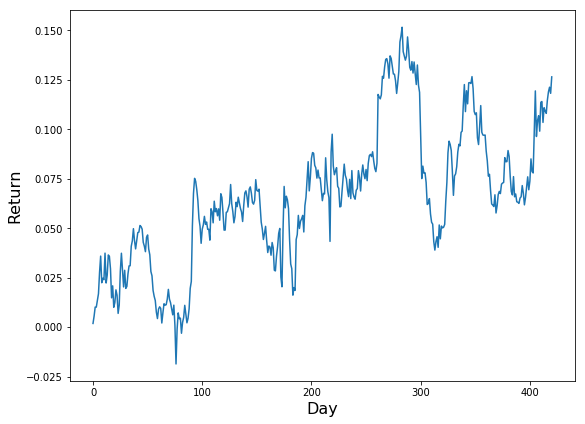

In [29]:
init = 100
position_test = []
for i, val in enumerate(list(predictions_test)):
    if val >= 0:
        position_test.append(1)
    else:
        position_test.append(-1)

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.tight_layout()
plt.plot(np.cumprod((np.array(position_test)*actuals_test)+1)-1);
plt.savefig(fname='test_returns', dpi=150)
plt.show()

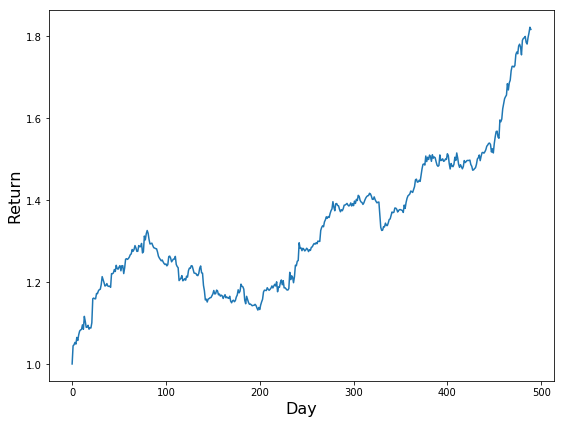

In [30]:
init = 100
position_train = []
for i, val in enumerate(list(predictions_train)):
    if val >= 0:
        position_train.append(1)
    else:
        position_train.append(-1)
        
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.tight_layout()
plt.plot(np.cumprod((np.array(position_train)*actuals_train)+1))
plt.savefig(fname='train_returns', dpi=150)
plt.show()